# Лабораторная работа 2.5: Градиентный спуск

## Формулировка задачи

Решается задача линейной регрессии: найти параметры прямой $y = wx + b$, которая наилучшим образом приближает данные (преобразование температуры из Цельсия в Фаренгейт).

## Методы решения

### 1. Метод наименьших квадратов (MMSE)

**Аналитическое решение** через систему линейных уравнений:

$$\begin{cases}
w\sum x_i^2 + b\sum x_i = \sum x_i y_i \\
w\sum x_i + b \cdot n = \sum y_i
\end{cases}$$

**Матричная форма:**
$$\begin{bmatrix}
\sum x_i^2 & \sum x_i \\
\sum x_i & n
\end{bmatrix}
\begin{bmatrix}
w \\
b
\end{bmatrix}
=
\begin{bmatrix}
\sum x_i y_i \\
\sum y_i
\end{bmatrix}$$

### 2. Градиентный спуск

**Итеративный алгоритм оптимизации:**

1. **Нормализация данных:** $x_{norm} = \frac{x - \mu_x}{\sigma_x}$, $y_{norm} = \frac{y - \mu_y}{\sigma_y}$
2. **Инициализация:** $w = 0$, $b = 0$
3. **Итерации:**
   - Вычисление градиентов:
     - $\frac{\partial E}{\partial w} = \frac{2}{n}\sum_{i=1}^{n} (y_{pred}^{(i)} - y^{(i)}) \cdot x^{(i)}$
     - $\frac{\partial E}{\partial b} = \frac{2}{n}\sum_{i=1}^{n} (y_{pred}^{(i)} - y^{(i)})$
   - Обновление параметров: $w := w - \alpha \cdot \frac{\partial E}{\partial w}$, $b := b - \alpha \cdot \frac{\partial E}{\partial b}$
4. **Денормализация:** возврат параметров к исходному масштабу

**Параметры:** learning_rate = 0.01, epochs = 10000

## Результаты

Оба метода дают одинаковые результаты (с точностью до численных погрешностей), что подтверждает корректность реализации градиентного спуска.


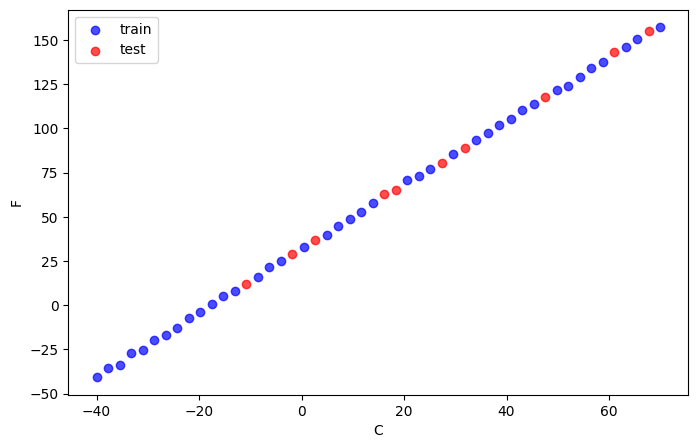

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from csv import DictWriter


if False:
    n_points = 50
    noise_std = 0.75
    X = np.linspace(-40, 70, n_points)
    Y = 9/5 * X + 32 + np.random.normal(0, noise_std, n_points)

    with open("dataset.csv", "w") as f:
        writer = DictWriter(f, fieldnames=("x", "y"))
        writer.writeheader()
        for x, y in zip(X, Y):
            writer.writerow(dict(x=x, y=y))


df = pd.read_csv("./dataset.csv")
X, Y = df['x'].to_numpy(), df['y'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, alpha=0.7, color='blue', label='train')
plt.scatter(X_test, y_test, alpha=0.7, color='red', label='test')
plt.xlabel('C')
plt.ylabel('F')
plt.legend()
plt.show()


In [2]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mmse_solve(X, y):
    n = len(X)
    A = np.array([[np.sum(X**2), np.sum(X)], [np.sum(X), n]])
    b = np.array([np.sum(X * y), np.sum(y)])
    w, b = np.linalg.solve(A, b)
    return w, b

w_mmse, b_mmse = mmse_solve(X_train, y_train)
y_pred_mmse = w_mmse * X_test + b_mmse
mse_mmse = mse(y_test, y_pred_mmse)

print(f"MMSE w={w_mmse:.4f}, b={b_mmse:.4f}, MSE={mse_mmse:.4f}")

MMSE w=1.8035, b=31.9245, MSE=0.7264


In [3]:
def gradient_descent(X, y, learning_rate=0.01, epochs=10000):
    X_mean, X_std = X.mean(), X.std()
    y_mean, y_std = y.mean(), y.std()
    X_norm = (X - X_mean) / X_std
    y_norm = (y - y_mean) / y_std
    
    w = 0.0
    b = 0.0
    n = len(X_norm)
    
    for epoch in range(epochs):
        y_pred = w * X_norm + b
        grad_w = (2/n) * np.sum((y_pred - y_norm) * X_norm)
        grad_b = (2/n) * np.sum(y_pred - y_norm)
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b
    
    w = w * y_std / X_std
    b = (b * y_std + y_mean) - w * X_mean
    
    return w, b

w_gd, b_gd = gradient_descent(X_train, y_train)
y_pred_gd = w_gd * X_test + b_gd
mse_gd = mse(y_test, y_pred_gd)

print(f"GD: w={w_gd:.4f}, b={b_gd:.4f}, MSE={mse_gd:.4f}")

GD: w=1.8035, b=31.9245, MSE=0.7264


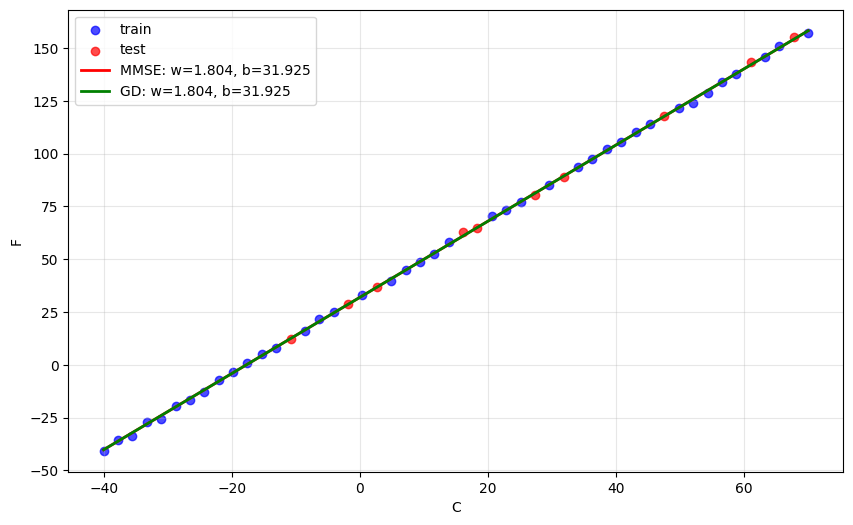

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.7, color='blue', label='train')
plt.scatter(X_test, y_test, alpha=0.7, color='red', label='test')
x_range = np.linspace(X.min(), X.max(), 100)
plt.plot(x_range, w_mmse * x_range + b_mmse, 'r-', linewidth=2, label=f'MMSE: w={w_mmse:.3f}, b={b_mmse:.3f}')
plt.plot(x_range, w_gd * x_range + b_gd, 'g-', linewidth=2, label=f'GD: w={w_gd:.3f}, b={b_gd:.3f}')
plt.xlabel('C')
plt.ylabel('F')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
